In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

First of all, the most important packages for pre-processing and machine learning are imported.

In [7]:
df = pd.read_csv("dataset_cancer.csv")
print(df)

C:\Users\stanl\AppData\Local\Temp\ipykernel_17908\4004721846.py:1: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset_cancer.csv")


                                       label_title label_organism  \
0              Gastric-fundus-Epithelium-Z000000SK   Homo sapiens   
1              Gastric-antrum-Epithelium-Z000000SP   Homo sapiens   
2              Lung-Alveolar-Endothelium-Z0000045H   Homo sapiens   
3               Gastric-antrum-Endocrine-Z00000438   Homo sapiens   
4               Lung-Bronchus-Epithelium-Z000000QD   Homo sapiens   
..                                             ...            ...   
317       Lung Squamous Cell Carcinoma [20A042131]   Homo sapiens   
318  Colon and rectum   Adenocarcinoma [20A042301]   Homo sapiens   
319       Lung Squamous Cell Carcinoma [20A042259]   Homo sapiens   
320  Colon and rectum   Adenocarcinoma [20A040906]   Homo sapiens   
321             Stomach Adenocarcinoma [20A042523]   Homo sapiens   

    label_gender label_age              label_tissue label_source_of_sample  \
0              F        28                   Stomach     Stomach_Epithelium   
1            

The dataset is loaded in.

# Pre-processing of the data

In [14]:
# a new column 'cancer_label' is added to the dataset
df['cancer_label'] = np.nan

healthy_tissues = ['Colon', 'Stomach', 'Lung']
cancer_tissues  = ['Colon and rectum cancer', 'Colon and rectum  cancer',
                   'Stomach cancer', 'Lung cancer']

# 1) Healthy samples → 0  (regardless of site label)
mask_healthy = df['label_tissue'].isin(healthy_tissues)
df.loc[mask_healthy, 'cancer_label'] = 0

# 2) Metastatic cancer → 2  (when cancer tissue AND site label contains 'Metastatic')
mask_metastatic = (
    df['label_tissue'].isin(cancer_tissues) &
    df['label_site label'].str.contains('Metastatic', case=False, na=False)
)
df.loc[mask_metastatic, 'cancer_label'] = 2

# 3) Primary cancer → 1  (when cancer tissue, NOT metastatic, AND site label is present)
mask_primary = (
    df['label_tissue'].isin(cancer_tissues) &
    ~mask_metastatic &
    df['label_site label'].notna() &
    (df['label_site label'].str.strip() != '')
)
df.loc[mask_primary, 'cancer_label'] = 1

# cancer_tissue with empty/missing site label remains NaN
df['cancer_label'] = df['cancer_label'].astype('Int64')

To be able to make the prediction model, a new column 'cancer_label' is added. The values can be either 0, 1, 2 or NaN, based on a couple of conditions. To evaluate which number value a sample gets in de cancer_label column , the column 'label_tissue' and 'label_site label' get evaluated. When the tissue of the sample is a healthy tissue, the value in cancer_label is 0. When the sample is a cancer tissue, and has 'metastatic' in label_site label, the value in cancer_label gets set to 2. For primary cancer samples, when label_tissue is a cancer tissue and label_site label is 'primary', the value gets set to 1. For samples where label_tissue is a cancer tissue, but there is a missing value in label_site label, we cannot attribute the sample to 'primary' or 'metastatic', therefore the value is set to NaN in the cancer_label column.

In [19]:
col = df.pop('cancer_label')

# Now the column 'cancer_label' gets positioned right after 'label_site label'
pos = df.columns.get_loc('label_site label') + 1
df.insert(pos, 'cancer_label', col)

After the preceding code, the 'cancer_label' column is placed as the last column in the dataset. To make it visually better, the column gets placed next to 'label_site label'.

In [24]:
df.head(40)

,label_title,label_organism,label_gender,label_age,label_tissue,label_source_of_sample,label_clinical stage,label_site label,cancer_label,chr1_958245_961305,...,chrX_48381489_48384549,chrX_135801738_135804798,chrX_52957457_52960517,chrX_48410876_48413936,chrX_154217728_154220788,chrX_72942763_72945823,chrX_152751861_152754921,chrX_152713548_152716608,chrX_135836269_135839329,chr5_70898619_70901679
0,Gastric-fundus-Epithelium-Z000000SK,Homo sapiens,F,28,Stomach,Stomach_Epithelium,NaN,NaN,0,0.171117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gastric-antrum-Epithelium-Z000000SP,Homo sapiens,F,28,Stomach,Stomach_Epithelium,NaN,NaN,0,0.179885,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lung-Alveolar-Endothelium-Z0000045H,Homo sapiens,F,81,Lung,Lung_Endothelium,NaN,NaN,0,0.179310,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gastric-antrum-Endocrine-Z00000438,Homo sapiens,M,36,Stomach,Stomach_Endocrine,NaN,NaN,0,0.190291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Lung-Bronchus-Epithelium-Z000000QD,Homo sapiens,F,64,Lung,Lung_Epithelium,NaN,NaN,0,0.174036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Lung-Interstitial-Macrophages-Z00000447,Homo sapiens,M,64,Lung,Lung_Macrophages,NaN,NaN,0,0.213287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Gastric-antrum-Epithelium-Z000000SR,Homo sapiens,F,44,Stomach,Stomach_Epithelium,NaN,NaN,0,0.192279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Gastric-fundus-Epithelium-Z000000RX,Homo sapiens,F,27,Stomach,Stomach_Epithelium,NaN,NaN,0,0.167073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Lung-Alveolar-Endothelium-Z000000Q1,Homo sapiens,F,28,Lung,Lung_Endothelium,NaN,NaN,0,0.170956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Lung-Alveolar-Endothelium-Z000000QK,Homo sapiens,F,76,Lung,Lung_Endothelium,NaN,NaN,0,0.169171,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Columns to exclude from processing
exclude_cols = ['label_title', 'label_organism', 'label_gender', 'label_age', 'label_tissue', 'label_source_of_sample', 'label_clinical stage', 'cancer_label', 'label_site label']

# This is a function to keep only float values in the feature columns, non-float values get replaced by "NaN"
def keep_floats(series):
    return series.apply(lambda x: x if isinstance(x, float) else np.nan)

# Apply the function to all columns except the metadata columns
for col in df.columns:
    if col not in exclude_cols:
        df[col] = keep_floats(df[col])

After a quick observation of the data, it stands out that not all missing values are displayed the same way. To fix this, all values in the feature columns that are not a number between 0 and 1 get automaticaly set to NaN; the meta-data columns get excluded from this because these columns contain value types other then numbers and would give bad results.

In [33]:
nan_percentage = df.isna().mean() * 100

The NaN percentage gets calculated for each column to be able to visualise the amount of NaN values. This is important because we want to build our model on the most informative data possible.

label_title                   0.000000
label_organism                0.000000
label_gender                  0.000000
label_age                     0.000000
label_tissue                  0.000000
                               ...    
chrX_72942763_72945823       99.689441
chrX_152751861_152754921     99.378882
chrX_152713548_152716608     99.068323
chrX_135836269_135839329    100.000000
chr5_70898619_70901679       99.689441
Length: 28788, dtype: float64


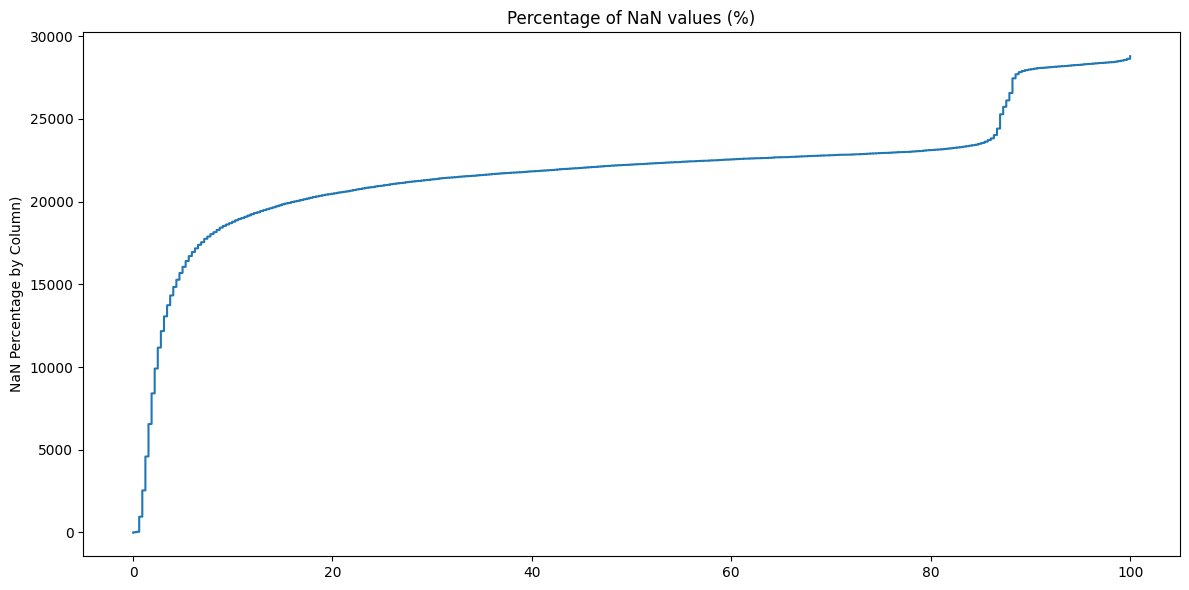

In [37]:
# Using the plt package, a plot is made to visualise the NaN percentage distribution
plt.figure(figsize=(12, 6))
print(nan_percentage)
plt.plot(nan_percentage.sort_values(),range(len(nan_percentage)))
plt.ylabel('NaN Percentage by Column)')
plt.title('Percentage of NaN values (%)')
plt.tight_layout()
plt.show()

This plot visualises the percentage of NaN values per column. Clearly there are a lot of columns which have a high NaN percentage, which means that these columns are not informative and are no real contribution for a prediction model.

In [42]:
# List of meta-data columns to always keep
metadata_cols = ['label_title', 'label_organism', 'label_gender', 'label_age', 'label_tissue', 'label_source_of_sample', 'label_clinical stage', 'cancer_label', 'label_site label']

# The columns that have to be kept in the DataFrame are the metadata columns and the columns with a NaN percentage of maximum 20%. 
cols_to_keep = [col for col in df.columns if (col in metadata_cols or nan_percentage[col] <= 20)]

# Now, the DataFrame gets subsetted to these columns
df = df[cols_to_keep]

The dataframe gets subsetted to only contain the feature columns with 20% or less NaN values. This is a good cutoff, based on the flattening of the curve in the plot above. (This means there is a big difference in NaN percentage between 2 groups of columns)

In [47]:
len(df.columns)

20472

In [50]:
bed_df = pd.read_csv('promoter_hg38_extended.bed', sep='\t')

The methylation atlas dataset gets loaded in. sep='\t' is used to make sure the column titles are not loaded in as a row.

In [57]:
# The chromosomal loci are renamed to their corresponding gene name in the bed_df
# Build a key in the BED table that matches methylation column names
bed_df['locus_key'] = (
    bed_df['chrom'].astype(str) + '_' +
    bed_df['chromStart'].astype(str) + '_' +
    bed_df['chromEnd'].astype(str)
)

# Create mapping: column name (locus) -> gene name
locus_to_gene = dict(zip(bed_df['locus_key'], bed_df['name']))

# Rename methylation columns using this mapping
df = df.rename(columns=locus_to_gene)

The BED file is used to replace the chromosomal loci with their corresponding gene names.

In [62]:
df.head(40)

,label_title,label_organism,label_gender,label_age,label_tissue,label_source_of_sample,label_clinical stage,label_site label,cancer_label,NOC2L_1,...,RAB39B_1,SPRY3_1,TMLHE_1,CD24_1,PDE4DIP_4,SMIM11A_1,KCNE1_2,ICOSLG_1,TMSB15B_1,TMSB15B_2
0,Gastric-fundus-Epithelium-Z000000SK,Homo sapiens,F,28,Stomach,Stomach_Epithelium,NaN,NaN,0,0.171117,...,0.442910,0.300476,0.300476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gastric-antrum-Epithelium-Z000000SP,Homo sapiens,F,28,Stomach,Stomach_Epithelium,NaN,NaN,0,0.179885,...,0.431908,0.285678,0.285678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Lung-Alveolar-Endothelium-Z0000045H,Homo sapiens,F,81,Lung,Lung_Endothelium,NaN,NaN,0,0.179310,...,0.521951,0.304902,0.304902,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gastric-antrum-Endocrine-Z00000438,Homo sapiens,M,36,Stomach,Stomach_Endocrine,NaN,NaN,0,0.190291,...,0.367241,0.077083,0.077083,0.600820,NaN,NaN,NaN,NaN,NaN,NaN
4,Lung-Bronchus-Epithelium-Z000000QD,Homo sapiens,F,64,Lung,Lung_Epithelium,NaN,NaN,0,0.174036,...,0.446903,0.282168,0.282168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Lung-Interstitial-Macrophages-Z00000447,Homo sapiens,M,64,Lung,Lung_Macrophages,NaN,NaN,0,0.213287,...,0.362069,0.075301,0.075301,0.717164,NaN,NaN,NaN,NaN,NaN,NaN
6,Gastric-antrum-Epithelium-Z000000SR,Homo sapiens,F,44,Stomach,Stomach_Epithelium,NaN,NaN,0,0.192279,...,0.519869,0.290936,0.290936,NaN,0.810000,NaN,NaN,NaN,NaN,NaN
7,Gastric-fundus-Epithelium-Z000000RX,Homo sapiens,F,27,Stomach,Stomach_Epithelium,NaN,NaN,0,0.167073,...,0.503917,0.356329,0.356329,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Lung-Alveolar-Endothelium-Z000000Q1,Homo sapiens,F,28,Lung,Lung_Endothelium,NaN,NaN,0,0.170956,...,0.451163,0.298718,0.298718,NaN,0.720000,NaN,NaN,NaN,NaN,NaN
9,Lung-Alveolar-Endothelium-Z000000QK,Homo sapiens,F,76,Lung,Lung_Endothelium,NaN,NaN,0,0.169171,...,0.472677,0.305307,0.305307,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
from sklearn.impute import KNNImputer

# List meta-data columns to exclude from imputation
metadata_cols = ['label_title', 'label_organism', 'label_gender', 'label_age', 'label_tissue', 'label_source_of_sample', 'label_clinical stage', 'cancer_label', 'label_site label']

# Select feature columns only for imputation
features = [col for col in df.columns if col not in metadata_cols]
df_features = df[features]

# Initialize and apply KNN imputer
imputer = KNNImputer(n_neighbors=3)
df_features_imputed = pd.DataFrame(imputer.fit_transform(df_features), columns=features)

# Concatenate meta-data columns back with imputed features
df_imputed = pd.concat([df[metadata_cols].reset_index(drop=True), df_features_imputed], axis=1)

To get rid of the remaining missing values, k-nearest-neighbour imputation was implemented. This is the best choice of imputation for datasets used for machine learning models, because this imputation better preserves local patterns and variation in the data.

In [70]:
df_imputed.head(30)

,label_title,label_organism,label_gender,label_age,label_tissue,label_source_of_sample,label_clinical stage,cancer_label,label_site label,NOC2L_1,...,RAB39B_1,SPRY3_1,TMLHE_1,CD24_1,PDE4DIP_4,SMIM11A_1,KCNE1_2,ICOSLG_1,TMSB15B_1,TMSB15B_2
0,Gastric-fundus-Epithelium-Z000000SK,Homo sapiens,F,28,Stomach,Stomach_Epithelium,NaN,0,NaN,0.171117,...,0.442910,0.300476,0.300476,0.533158,0.812381,0.32081,0.558405,0.084586,0.349428,0.349428
1,Gastric-antrum-Epithelium-Z000000SP,Homo sapiens,F,28,Stomach,Stomach_Epithelium,NaN,0,NaN,0.179885,...,0.431908,0.285678,0.285678,0.533158,0.812381,0.32081,0.558405,0.084586,0.349428,0.349428
2,Lung-Alveolar-Endothelium-Z0000045H,Homo sapiens,F,81,Lung,Lung_Endothelium,NaN,0,NaN,0.179310,...,0.521951,0.304902,0.304902,0.570728,0.812381,0.32081,0.558405,0.084586,0.349428,0.349428
3,Gastric-antrum-Endocrine-Z00000438,Homo sapiens,M,36,Stomach,Stomach_Endocrine,NaN,0,NaN,0.190291,...,0.367241,0.077083,0.077083,0.600820,0.723165,0.32081,0.558405,0.084586,0.349428,0.349428
4,Lung-Bronchus-Epithelium-Z000000QD,Homo sapiens,F,64,Lung,Lung_Epithelium,NaN,0,NaN,0.174036,...,0.446903,0.282168,0.282168,0.397408,0.812381,0.32081,0.558405,0.084586,0.349428,0.349428
5,Lung-Interstitial-Macrophages-Z00000447,Homo sapiens,M,64,Lung,Lung_Macrophages,NaN,0,NaN,0.213287,...,0.362069,0.075301,0.075301,0.717164,0.693165,0.32081,0.558405,0.084586,0.349428,0.349428
6,Gastric-antrum-Epithelium-Z000000SR,Homo sapiens,F,44,Stomach,Stomach_Epithelium,NaN,0,NaN,0.192279,...,0.519869,0.290936,0.290936,0.533158,0.810000,0.32081,0.558405,0.084586,0.349428,0.349428
7,Gastric-fundus-Epithelium-Z000000RX,Homo sapiens,F,27,Stomach,Stomach_Epithelium,NaN,0,NaN,0.167073,...,0.503917,0.356329,0.356329,0.533158,0.812381,0.32081,0.558405,0.084586,0.349428,0.349428
8,Lung-Alveolar-Endothelium-Z000000Q1,Homo sapiens,F,28,Lung,Lung_Endothelium,NaN,0,NaN,0.170956,...,0.451163,0.298718,0.298718,0.570728,0.720000,0.32081,0.558405,0.084586,0.349428,0.349428
9,Lung-Alveolar-Endothelium-Z000000QK,Homo sapiens,F,76,Lung,Lung_Endothelium,NaN,0,NaN,0.169171,...,0.472677,0.305307,0.305307,0.532044,0.812381,0.32081,0.558405,0.084586,0.349428,0.349428


# Data exploration

In [77]:
from scipy.stats import f_oneway

metadata_cols = [
    'label_title', 'label_organism', 'label_gender', 'label_age',
    'label_tissue', 'label_source_of_sample',
    'label_clinical stage',
    'label_site label', 'cancer_label'
]

# A new DataFrame is build by copying the imputed DataFrame and now filtering to only contain the samples without NaN in 'cancer_label'
df_anova = df_imputed.copy()
df_anova['cancer_label'] = df_anova['cancer_label'].astype('Int64')

df_anova = df_anova[df_anova['cancer_label'].notna()].copy() #filter for samples without NaN in 'cancer_label'
df_anova['cancer_label'] = df_anova['cancer_label'].astype(int)

# To make sure the ANOVA is done only on the feature columns, the metadata columns are excluded 
feature_cols = [c for c in df_anova.columns if c not in metadata_cols]

results = []
groups_ids = sorted(df_anova['cancer_label'].unique())

for col in feature_cols:
    groups = [
        df_anova.loc[df_anova['cancer_label'] == g, col].values
        for g in groups_ids
    ]
    if any(len(g) < 2 for g in groups):
        continue

    F, p = f_oneway(*groups)

    mean_per_group = {
        'mean_healthy'   : np.mean(groups[groups_ids.index(0)]),
        'mean_primary'   : np.mean(groups[groups_ids.index(1)]),
        'mean_metastatic': np.mean(groups[groups_ids.index(2)]),
    }

    results.append({'locus': col, 'F_stat': F, 'p_value': p, **mean_per_group})

anova_cancer = pd.DataFrame(results).sort_values('p_value')

Before building a model, we performed an ANOVA test to visualise whether there is indeed a difference in mean methylation between the different groups and if so, these differences are significant. The ANOVA also allows us to see which features contribute most to a correct classification of the model. We perform a one-way ANOVA because we want to see the mean methylation per group per locus. The ANOVA only needs to be performed on the chromosomal loci, so the metadata columns are again excluded. The mean per group gets calculated for every locus in the imputed dataset, together with a p-value and an F-statistic.

In [83]:
print(anova_cancer.head())

          locus        F_stat        p_value  mean_healthy  mean_primary  \
10882  ZNF587_1  27068.815984  4.693624e-322      0.367577      0.051372   
7276    YPEL3_2  26404.288456  1.511841e-320      0.629781      0.055900   
2053    MCM10_1  24990.084754  3.311762e-317      0.376192      0.052672   
10371   GSK3A_4  24621.892637  2.634283e-316      0.666566      0.052568   
8582     SNF8_1  21356.547488  1.120211e-307      0.465848      0.053109   

       mean_metastatic  
10882         0.051784  
7276          0.055674  
2053          0.052742  
10371         0.052444  
8582          0.051421  


The results obtained from the ANOVA indicate that there is a significant difference in methylation between healthy individuals and individuals with primary or metastatic cancer. The corresponding p-value is extremely low, indicating highly significant differences. There is virtually no difference in average methylation between “primary” and “metastatic” cancer, but due to the significant p-value, we have decided to try to build a classification model.

# Machine Learning models

## RandomForest classification model

In [91]:
# The first classification model will be a RandomForest
# We use the imputed dataframe with the column cancer_label defined
df_rf = df_imputed[df_imputed['cancer_label'].notna()].copy()
df_rf['cancer_label'] = df_rf['cancer_label'].astype(int)

metadata_cols = [
    'label_title', 'label_organism', 'label_gender', 'label_age',
    'label_tissue', 'label_source_of_sample',
    'label_clinical stage',
    'label_site label', 'cancer_label'
]

feature_cols = [c for c in df_rf.columns if c not in metadata_cols]

X = df_rf[feature_cols].values
y = df_rf['cancer_label'].values

To start making the RandomForest classifier, a new DataFrame, df_rf, is made. This DataFrame contains the imputed dataset, without the samples with a missing value in the 'cancer_label' column because these are not informative to train the model. The features (X) and targets (Y) are defined. The features are the chromosomal loci and the targets are 0, 1 and 2 in the 'cancer_label' column, which in essence define 'healthy', 'primary' or 'metastatic'.

In [96]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

A train-test split of 80% training data and 20% test data is chosen. In this code, 'stratify = y' is very important, because stratification ensures that the train-test split represents the same proportions of classes as the original dataset. Without stratification, there would be a chance that for example the model gets trained only on 'primary' and 'metastatic' samples, because the dataset contains less 'healthy' samples.

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier

k_features = 200 # here we select for the top 200 most informative loci in the dataset

rf_pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=k_features)), # the function f_classif performs an ANOVA test for each single locus in the dataset, SelectKBest then ranks every locus based on these F-scores.
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('select', SelectKBest(k=200)),
                ('clf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

SelectKBest, f_classif and k_features = 200 are used to select for the top200 features that are the most informative in the dataset. This is a form of dimensionality reduction and it reduces the chance of overfitting the model. In this way, it prevents the model from memorizing noise in the data, which could lead to really good train results but bad test results. n_estimators is set to 300, which means the model uses 300 decision trees to do the classification.

In [106]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = rf_pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[ 8  0  0]
 [ 0 32  0]
 [ 0  3 14]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.914     1.000     0.955        32
           2      1.000     0.824     0.903        17

    accuracy                          0.947        57
   macro avg      0.971     0.941     0.953        57
weighted avg      0.952     0.947     0.946        57



As can be deduced from the confusion matrix, the model is successfull in distinguishing between “healthy”, “primary” and “metastatic” cancer patients. The 'precision' means, out of all predicted as class X, how many where actually class X? For class 0 (healthy) and 2 (metastatic) the precision is 1, indicating a perfect prediction of the samples. For class 1 (primary) the precision is 91,4% because the model put some of the class 2 samples in class 1. The 'recall' means, out of all actuall class X, how many did the model find? For class 0 and 1 the recall is 1, meaning that the model found all samples of the actuall classes. For class 2 (metastatic), the model calles some of them class 1, so it found only 82,4% of the actuall class 2 samples. The F1-score indicates how strong the model performes, in this case very strong with F1-scores higher then 90% for all 3 groups/classes. Finally, the accuracy indicates the percentage of total guesses that where correct, in this case 94,7%, which is very high.

In [113]:
from sklearn.metrics import accuracy_score
test_accuracy_rf = accuracy_score(y_test, y_pred)
print("Accuracy:", test_accuracy_rf)

Accuracy: 0.9473684210526315


In [117]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='accuracy')
print("CV accuracies:", scores)
print("Mean CV accuracy:", scores.mean())

CV accuracies: [0.98245614 0.9122807  0.94736842 0.92982456 0.92857143]
Mean CV accuracy: 0.9401002506265664


Cross-validation is implemented to detect overfitting. In cross-validation, each sample gets used as test-data at least one time, so the model gets validated against various data splits ensuring that the model has not just memorized the training data.

In [121]:
# New split with larger test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

# The same pipeline object gets refitted on the new training data
rf_pipeline.fit(X_train, y_train)

y_pred = rf_pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[15  0  0]
 [ 0 64  0]
 [ 0  7 28]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        15
           1      0.901     1.000     0.948        64
           2      1.000     0.800     0.889        35

    accuracy                          0.939       114
   macro avg      0.967     0.933     0.946       114
weighted avg      0.945     0.939     0.937       114



Here, the train-test split gets changed to 60% train and 40% test as another way of validating the performance of the model. The model still shows similar results as the previous train-test split of 80% train and 20% test data.

In [126]:
# Now we do inspection of the importance of the features, to see which feature contributes the most to the classification
# Get mask of the k features kept by SelectKBest
support = rf_pipeline.named_steps['select'].get_support()
selected_features = np.array(feature_cols)[support]

# Get their importances from the RandomForest
importances = rf_pipeline.named_steps['clf'].feature_importances_

# Put into a DataFrame and sort
feat_imp = pd.DataFrame({
    'locus': selected_features,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp.head(20))   # the result gets headed to the top 20 most important loci

         locus  importance
89     TERF2_1    0.039124
8      SNIP1_1    0.031993
103     DOHH_1    0.030878
102    AP3D1_1    0.029555
14   LAMTOR5_2    0.028864
156     RPL3_1    0.028498
124  C2orf42_1    0.015414
36    ZDHHC5_2    0.014220
35    ZDHHC5_3    0.013741
37    ZDHHC5_1    0.013583
60     DDX51_1    0.013078
68     BAZ1A_1    0.011969
194    ZNF16_1    0.011243
42    FAM89B_1    0.010697
44     RAB6A_1    0.010494
7     RNF19B_1    0.010487
147    ADRM1_2    0.010387
58     TAOK3_1    0.009946
146    FITM2_1    0.009540
26     DESI2_1    0.009337


As an extra step, we check the importances of the features to see which feature (or locus) contributes the most to the classification model. This can be very helpfull in terms of medical applications, to see if there are certain loci that jump out or methylation of certain loci that are completely irrelevant to determine cancer. The importances of all loci in the dataset together add up to 1 (or 100%). TERF2_1 for example has an importance of 0,039124 or 3,9%, while DESI2_1 for example has an importance of 0,93%. Although the absolute values of these feature importances seem low, this means that TERF2_1 is roughly 4 times more important than DESI2_1.   

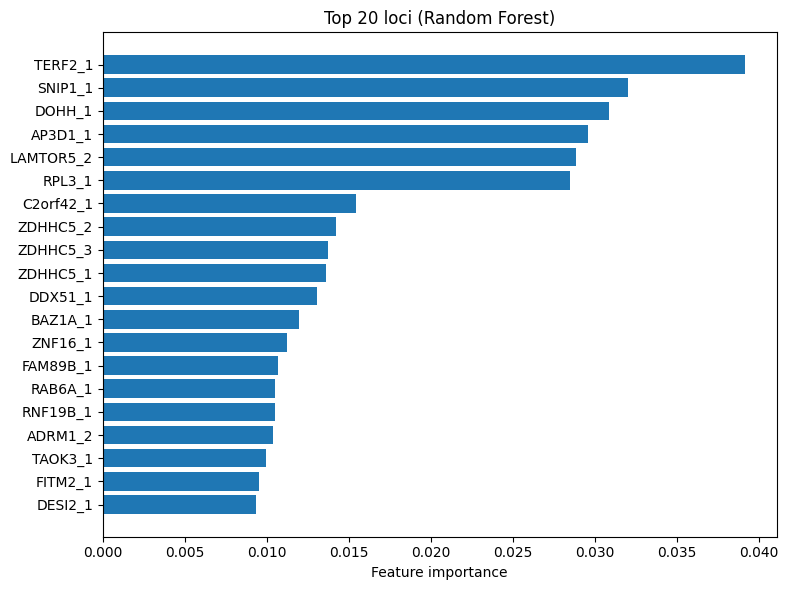

In [131]:
top_n = 20
top = feat_imp.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(top['locus'], top['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature importance')
plt.title(f'Top {top_n} loci (Random Forest)')
plt.tight_layout()
plt.show()

This plots visualises the importances of the 20 most important features in the dataset. 

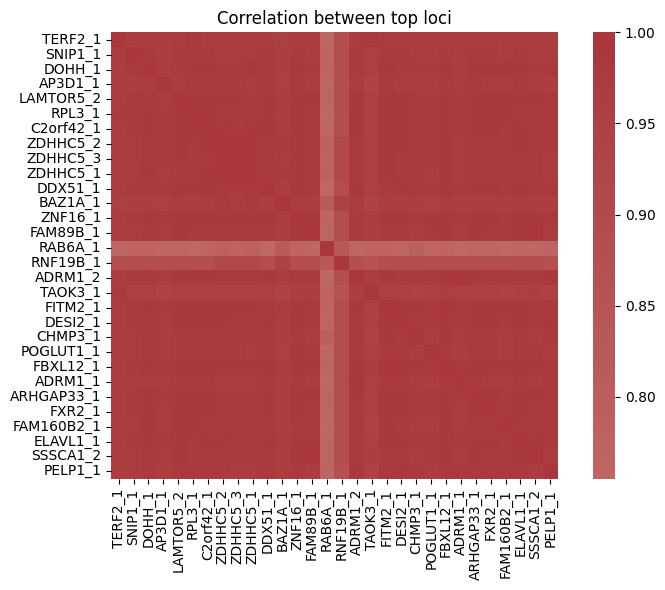

In [137]:
# now computing correlations between loci
# We now take the top 30 loci in the dataset
top_n = 30
top_loci = feat_imp.head(top_n)['locus'].tolist()

# Subset the imputed dataframe to these loci
corr_df = df_imputed[top_loci]

# A correlation matrix is drawn up
corr = corr_df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr, cmap='vlag', center=0, square=True)
plt.title('Correlation between top loci')
plt.tight_layout()
plt.show()

Another handy approach is seeing if some loci are in a way correlated to eachother. This is visualised by this correlation matrix. 

In [150]:
# With this code, only the upper triangle in the correlation matrix is kept, in this way excluding self-correlation
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

pairs = (
    upper.stack()
         .reset_index()
)
pairs.columns = ['locus_1', 'locus_2', 'corr']

# Filter for strongly correlated pairs, we take a treshold of 0,95
high_corr_pairs = pairs[pairs['corr'].abs() > 0.95] \
                      .sort_values('corr', ascending=False)

print(high_corr_pairs.head(30))   # head for the top 20 strongest correlated pairs

       locus_1     locus_2      corr
313   FAM89B_1    SSSCA1_2  0.999992
183   ZDHHC5_2    ZDHHC5_1  0.999400
182   ZDHHC5_2    ZDHHC5_3  0.999028
204   ZDHHC5_3    ZDHHC5_1  0.998493
372    FITM2_1    FBXL12_1  0.992047
350    ADRM1_2     ADRM1_1  0.991833
291    ZNF16_1    FBXL12_1  0.991315
408   FBXL12_1  ARHGAP33_1  0.991201
382    DESI2_1    FBXL12_1  0.991194
296    ZNF16_1    ELAVL1_1  0.991099
287    ZNF16_1     FITM2_1  0.990750
72      DOHH_1     FITM2_1  0.990301
282    ZNF16_1    FAM89B_1  0.990024
297    ZNF16_1    SSSCA1_2  0.989986
129  LAMTOR5_2  ARHGAP33_1  0.989796
66      DOHH_1     ZNF16_1  0.989783
117  LAMTOR5_2     ZNF16_1  0.989661
377    FITM2_1    ELAVL1_1  0.989528
174  C2orf42_1    FBXL12_1  0.989490
127  LAMTOR5_2    FBXL12_1  0.989477
123  LAMTOR5_2     FITM2_1  0.989195
375    FITM2_1      FXR2_1  0.989102
135     RPL3_1   C2orf42_1  0.988557
411   FBXL12_1    ELAVL1_1  0.988554
294    ZNF16_1      FXR2_1  0.988543
374    FITM2_1  ARHGAP33_1  0.988519
1

As can be seen from the correlation scores, some of the top 30 loci are very strongly correlated to each other, which means they carry the same signal. 

In [155]:
#the top loci are almost perfectly correlated which means they carry the same signal, now we keep 1 representative from each correlation group 
threshold = 0.98

to_drop = set()
for i, row in high_corr_pairs.iterrows():
    l1, l2, c = row['locus_1'], row['locus_2'], row['corr']
    if c > threshold:
        # if one locus is already chosen to be kept, drop the other
        if l1 not in to_drop and l2 not in to_drop:
            # drop locus 2, keep locus 1 as representative
            to_drop.add(l2)

print("Loci to drop due to high correlation:", len(to_drop))

Loci to drop due to high correlation: 20


Due to the high correlation, the loci carry the same signal, which can mean they are redundant. 

In [163]:
reduced_feature_cols = [f for f in feature_cols if f not in to_drop]
X_red = df_rf[reduced_feature_cols].values

X_train, X_test, y_train, y_test = train_test_split(
    X_red, y, test_size=0.2, stratify=y, random_state=42
)

rf_pipeline.fit(X_train, y_train)
y_pred = rf_pipeline.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.914     1.000     0.955        32
           2      1.000     0.824     0.903        17

    accuracy                          0.947        57
   macro avg      0.971     0.941     0.953        57
weighted avg      0.952     0.947     0.946        57



The performance stays the same, which means these loci are redundant. The remaining loci and their importances then better reflect distinct signals rather than many copies of the same one.

In [167]:
# now RandomForest on all features in the dataset
# Build X and y using ALL methylation features
df_rf_2 = df_imputed[df_imputed['cancer_label'].notna()].copy()
df_rf_2['cancer_label'] = df_rf_2['cancer_label'].astype(int)

metadata_cols = [
    'label_title', 'label_organism', 'label_gender', 'label_age',
    'label_tissue', 'label_source_of_sample',
    'label_clinical stage',
    'label_site label', 'cancer_label'
]

feature_cols = [c for c in df_rf_2.columns if c not in metadata_cols]

X = df_rf_2[feature_cols].values   # ALL features
y = df_rf_2['cancer_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# RandomForest without SelectKBest
rf_full = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_full.fit(X_train, y_train)

y_pred = rf_full.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred))

[[ 8  0  0]
 [ 0 32  0]
 [ 0  0 17]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      1.000     1.000     1.000        32
           2      1.000     1.000     1.000        17

    accuracy                          1.000        57
   macro avg      1.000     1.000     1.000        57
weighted avg      1.000     1.000     1.000        57

Accuracy: 1.0


A RandomForest model using all features in the dataset gives the best possible scores. To evaluate if this is due to overfitting or really because the model works perfect, we perform a cross-validation. 

In [169]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_full, X, y, cv=cv, scoring='accuracy')
print("CV accuracies:", scores)
print("Mean CV accuracy:", scores.mean())

CV accuracies: [0.98245614 1.         1.         1.         1.        ]
Mean CV accuracy: 0.9964912280701753


After cross-validation, almost all tests give an accuracy of 1, except the first test which gives an accuracy of 0.98. This means that either the model indeed works perfectly, or there is data-leakage. 

In [172]:
from sklearn.model_selection import permutation_test_score


score, permutation_scores, pvalue = permutation_test_score(
    rf_full, X, y, scoring="accuracy", cv=cv, n_permutations=100
)

print(f"Original Accuracy: {score:.4f}")
print(f"P-value: {pvalue:.4f}")

Original Accuracy: 0.9965
P-value: 0.0099


Data-leakage can be detected by using data shuffling. With data-shuffling the target-labels get randomly assigned to different samples (so the samples get the wrong target variable assigned), but the features stay the same. With data-shuffling the model should only get a maximum of 33,3% of the guesses right, so no better than random guessing. If the model still performs with an almost perfect accuracy and a p-value > 0,05, this means there is data-leakage and/or overfitting and the model can detect patterns in random noise. 
Here, according to the p-value of 0,0099, the original accuracy of the model can be accepted as true. Although this suggests that the model does indeed make perfect classification, we remain sceptic about this results, also because of the small sample size and disproportional distribution of 'healthy', 'primary' and 'metastatic'.

## Logistic Regression model

Another method of making a classification model is by using logistic regression.

In [190]:
metadata_cols = [
    'label_title', 'label_organism', 'label_gender', 'label_age',
    'label_tissue', 'label_source_of_sample',
    'label_clinical stage',
    'label_site label', 'cancer_label'
]

df_lr = df_imputed[df_imputed['cancer_label'].notna()].copy()
df_lr['cancer_label'] = df_lr['cancer_label'].astype(int)

feature_cols = [c for c in df_lr.columns if c not in metadata_cols]

X = df_lr[feature_cols].values
y = df_lr['cancer_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

The same preparation steps are taken as in the RandomForest model. Again a new DataFrame is created with the same samples and a train-test split of 80% train and 20% test data is used.

In [192]:
from sklearn.linear_model import LogisticRegression

k_features = 200  # select for the top 200 loci in the dataset

logreg_pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=k_features)),
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(
        multi_class='multinomial',   
        solver='lbfgs',              
        max_iter=2000,               
        n_jobs=-1
    ))
])

logreg_pipeline.fit(X_train, y_train)

C:\Users\stanl\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('select', SelectKBest(k=200)), ('scale', StandardScaler()),
                ('clf',
                 LogisticRegression(max_iter=2000, multi_class='multinomial',
                                    n_jobs=-1))])

StandardScaler() is used to standardize the data. It adjusts the values in each feature so that they are all on the same scale, namely the mean centered around zero and a variance of 1. Again the top 200 loci are used as features to predict the three target groups.

In [196]:
y_pred = logreg_pipeline.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print("Accuracy:", accuracy_lr)

[[ 8  0  0]
 [ 0 32  0]
 [ 0  3 14]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.914     1.000     0.955        32
           2      1.000     0.824     0.903        17

    accuracy                          0.947        57
   macro avg      0.971     0.941     0.953        57
weighted avg      0.952     0.947     0.946        57

Accuracy: 0.9473684210526315


The logistic regression classification model is comparable with the RandomForest classifier in terms of results. It has the same accuracy and is equally good in classifying the different samples.

## Neural network model

In [200]:
#neural network
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

metadata_cols = [
    'label_title', 'label_organism', 'label_gender', 'label_age',
    'label_tissue', 'label_source_of_sample',
    'label_clinical stage',
    'label_site label', 'cancer_label'
]

df_nn = df_imputed[df_imputed['cancer_label'].notna()].copy()
df_nn['cancer_label'] = df_nn['cancer_label'].astype(int)

feature_cols = [c for c in df_nn.columns if c not in metadata_cols]

X = df_nn[feature_cols].values
y = df_nn['cancer_label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Again the same preparation is needed for this model. The new DataFrame is now called 'df_nn', but in essence it is the same DataFrame as used in the other models. Again a train-test split of 80% train and 20% test data is implemented.

In [204]:
from sklearn.neural_network import MLPClassifier

k_features = 200  # reuse top 200 loci to limit overfitting

nn_pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=k_features)),
    ('scale', StandardScaler()),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(100, 50),  # 2 hidden layers are used
        activation='relu',
        solver='adam',
        alpha=1e-4,         
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=500,
        random_state=42
    ))
])

nn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('select', SelectKBest(k=200)), ('scale', StandardScaler()),
                ('clf',
                 MLPClassifier(hidden_layer_sizes=(100, 50),
                               learning_rate='adaptive', max_iter=500,
                               random_state=42))])

The data is again scaled to have a mean around 0 and a variance of 1. Just as in the previous classification models, k_features is set to 200 to use the top 200 loci as features. The neural network consists of 2 hidden layers, the first one has 100 neurons, the second one has 50 neurons.

In [208]:
y_pred = nn_pipeline.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))
print("Accuracy:", accuracy_nn)

[[ 8  0  0]
 [ 0 28  4]
 [ 0  3 14]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           1      0.903     0.875     0.889        32
           2      0.778     0.824     0.800        17

    accuracy                          0.877        57
   macro avg      0.894     0.900     0.896        57
weighted avg      0.879     0.877     0.878        57

Accuracy: 0.8771929824561403


This model still performs relatively well, albeit not as good as the RandomForest and Logistic Regression models. The accuracy is lower (94,7% versus 87,7%) as is the precision and recall in both the first and second class. The model is less effective in classifying 'primary' and 'metastatic' samples.

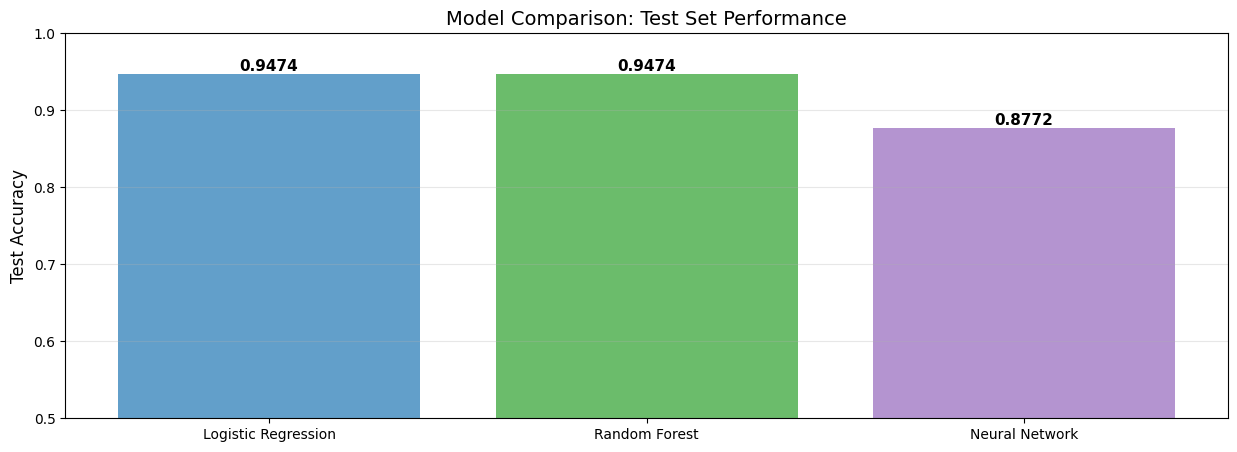

In [213]:
# Visualize comparison between the three different models
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

# Bar plot of test accuracies
model_names = ['Logistic Regression', 'Random Forest', 'Neural Network']
accuracies = [accuracy_lr, test_accuracy_rf, accuracy_nn]
colors_chart = ['#1f77b4', '#2ca02c', '#9467bd']
bars = ax1.bar(model_names, accuracies, color=colors_chart, alpha=0.7)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Model Comparison: Test Set Performance', fontsize=14)
ax1.set_ylim([0.5, 1.0])
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

This is a visualisation of the test_accuracies of the different models. In this plot we can clearly see that the logistic regression model and RandomForest model take the upperhand. 

## Second RandomForest model

In [220]:
#now we will make the same RandomForest model but just where it predicts 'healthy' or 'metastatic'
#first we need to make a new column where 'healthy' = 0 and 'metastatic' = 1
#use df_impute and make new df where all 'cancer_label' = 1 now NA, after this delete all NA in 'cancer_label' to only keep 'healthy' and 'metastatic'
df_filtered_2 = df_imputed.copy()

df_filtered_2.loc[df_filtered_2['cancer_label'] == 1, 'cancer_label'] = np.nan

df_filtered_2 = df_filtered_2[df_filtered_2['cancer_label'].notna()].copy()

#make all integer
df_filtered_2['cancer_label'] = df_filtered_2['cancer_label'].astype(int)

In the ANOVA test we performed, the mean methylation values between 'primary' and 'metastatic' showed no real difference, while the mean methylation between 'healthy' and both 'primary' and 'metastatic' was quite big. Because of this big difference in methylation, the assumption that a classification model would be perfectly able to differentiate between 'healthy' and 'metastatic' is justified. To test how good such a model would perform, we made a RandomForest classification model with the targets 'healthy' and 'metastatic'. For this, a new DataFrame is made in which all 'primary' samples get NaN as value, after which these samples can get eliminated. In this way the new DataFrame (df_filtered_2) contains only 'healthy' and 'metastatic' samples.

In [225]:
df_ml_2 = df_filtered_2
df_ml_2['cancer_label'] = df_ml_2['cancer_label'].astype(int)

metadata_cols = [
    'label_title', 'label_organism', 'label_gender', 'label_age',
    'label_tissue', 'label_source_of_sample',
    'label_clinical stage',
    'label_site label', 'cancer_label'
]

feature_cols = [c for c in df_ml_2.columns if c not in metadata_cols]

X = df_ml_2[feature_cols].values
y = df_ml_2['cancer_label'].values

In [233]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Again a train-test split of 80% train and 20% test data is used.

In [237]:
k_features = 200 

rf_pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif, k=k_features)),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('select', SelectKBest(k=200)),
                ('clf',
                 RandomForestClassifier(n_estimators=300, n_jobs=-1,
                                        random_state=42))])

Again the top200 loci are used as features for the model.

In [239]:
y_pred = rf_pipeline.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

[[ 8  0]
 [ 0 17]]
              precision    recall  f1-score   support

           0      1.000     1.000     1.000         8
           2      1.000     1.000     1.000        17

    accuracy                          1.000        25
   macro avg      1.000     1.000     1.000        25
weighted avg      1.000     1.000     1.000        25



After running this classification model, the results are perfect with a precision, recall, F1-score and accuracy of 1. This could indicate overfitting, but based on the fact that the mean methylation values of both groups are so different, the most logic interpretation is that the model can perfectly separate between healthy and metastatic samples.

In [243]:
#cross-validation to detect overfitting
#here every sample is test data once, when all accuracies stay one this means that the model makes perfect predictions
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='accuracy')
print("Fold accuracies:", scores)
print("Mean CV accuracy:", scores.mean())

Fold accuracies: [1. 1. 1. 1. 1.]
Mean CV accuracy: 1.0


To test for overfitting, cross-validation was performed using 5 splits. Via cross-validation, each sample gets to be test-data at least one time ensuring that not the same data is tested over and over. The results are constant, meaning every test the accuracy stays 1. This indicates no overfitting and that the model makes perfect predictions.